### [GLOBAL IMPORTS]

In [62]:
from pathlib import Path
import kaggle
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor

from fastai.data.external import URLs
from fastai.tabular.core import (
     TabularPandas, Categorify, FillMissing, 
     cont_cat_split, add_datepart, 
     save_pickle, #load_pickle
)

from fastbook import draw_tree

import tarfile
import zipfile

# This is the code from the old file_extract function in fastai.data.external. 
# See here for when it disappeared in favor of fastdownload:
# https://github.com/fastai/fastai/commit/63b624c696c956a850cc137878d2582402c1db92
def file_extract_deprecated(fname, dest=None):
     "Extract `fname` to `dest` using `tarfile` or `zipfile`."
     if dest is None: 
          dest = Path(fname).parent
     fname = str(fname)
     if   fname.endswith('gz'):  
          tarfile.open(fname, 'r:gz').extractall(dest)
     elif fname.endswith('zip'): 
          zipfile.ZipFile(fname     ).extractall(dest)
     else: 
          raise Exception(f'Unrecognized archive: {fname}')


In [2]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [3]:
# personal key redacted
creds = 'get-your-key-from-kaggle'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path = URLs.path('bluebook')
path

Path('/Users/mton/.fastai/archive/bluebook')

In [5]:
# Use Kaggle API to download dataset to that path and extract it

if not path.exists():
    path.mkdir()
    # https://www.kaggle.com/c/bluebook-for-bulldozers/rules
    # MUST accept rules else:
    # - download request will time out
    kaggle.api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract_deprecated(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('/Users/mton/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/Users/mton/.fastai/archive/bluebook/Valid.csv'),Path('/Users/mton/.fastai/archive/bluebook/median_benchmark.csv'),Path('/Users/mton/.fastai/archive/bluebook/Test.csv'),Path('/Users/mton/.fastai/archive/bluebook/ValidSolution.csv'),Path('/Users/mton/.fastai/archive/bluebook/Machine_Appendix.csv'),Path('/Users/mton/.fastai/archive/bluebook/TrainAndValid.csv')]

In [6]:
# @audit : Explain why we are setting low_memory=False, by default it's TRUE
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [7]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [8]:
# Tell panda an explicit order for each categorie
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [9]:
# The dependent variable is the most important data column
dep_var = 'SalePrice'
# running this cell repeated will apply LOG on each run!
# Only do it once! @audit : why?
df[dep_var] = np.log(df[dep_var])
df[dep_var]

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64

### Decision Trees

In [10]:
df = add_datepart(df, 'saledate')

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [11]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [12]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [14]:
procs = [Categorify, FillMissing]

#### Difference between sets [timeseries]

- Training
- Validation
- Test

And the implications when we are dealing with a time series

In [21]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(-cond)[0]

splits = (list(train_idx), list(valid_idx))

#### Get Data

Build a Table where :
- Data are converted to NUMERIC values
- Fill in MISSING (empty) container values

In [27]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)

(404710, 7988)

In [28]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [29]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,...,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,...,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,...,57,1,1,1,1,1,1,1.077754e+09,1,1


In [31]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [34]:
type(to)

fastai.tabular.core.TabularPandas

In [52]:
save_pickle(path/'to.pk1', to)
# to = load_pickle(path/'to.pk1') # load pk1

#### Creating the Decision Tree

In [55]:
# define our dependent and independent variable
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

# now that all our data is numeric and there are no missing values
# we can create a decision tree
m = DecisionTreeRegressor(max_leaf_nodes=4)

In [56]:
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

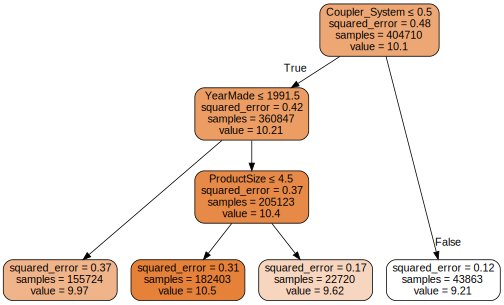

In [61]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)